In [2]:
import pandas as pd
import numpy as np
from collections import Counter
from tqdm import tqdm
from joblib import Parallel, delayed
from math import floor, ceil
import os
import pickle

# Reading Each File

* title.basics: Contains basic information like titleName, genres, runtime, startYear, etc.
* title.ratings: Contains IMDb rating information for titles.
* title.crew: Contains list of directors and writers for each title
* title.principals: Contains list of the cast for each title
* names.basics: Contains basic information about a person like name, birthYear, deathYear, along with the titles they are most known for.
* title.akas: Contains information on the various versions/languages/regions a title is released in.

## Title Basics

In [3]:
## Load the data Title Basics
title_basics = pd.read_csv("title.basics.tsv", sep="\t", low_memory=False)

## Get some information overview
print(f"{title_basics.info()}")
print(f"{title_basics.head()}")
print(f"{title_basics.columns}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11497554 entries, 0 to 11497553
Data columns (total 9 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   tconst          object
 1   titleType       object
 2   primaryTitle    object
 3   originalTitle   object
 4   isAdult         object
 5   startYear       object
 6   endYear         object
 7   runtimeMinutes  object
 8   genres          object
dtypes: object(9)
memory usage: 789.5+ MB
None
      tconst titleType            primaryTitle           originalTitle  \
0  tt0000001     short              Carmencita              Carmencita   
1  tt0000002     short  Le clown et ses chiens  Le clown et ses chiens   
2  tt0000003     short            Poor Pierrot          Pauvre Pierrot   
3  tt0000004     short             Un bon bock             Un bon bock   
4  tt0000005     short        Blacksmith Scene        Blacksmith Scene   

  isAdult startYear endYear runtimeMinutes                    genres  
0       0      

### Title Basics Shape

In [4]:
print(f"Number of Rows: {title_basics.shape[0]}")
print(f"Number of Columns: {title_basics.shape[1]}")
print(f"{title_basics.isna().sum()}")

Number of Rows: 11497554
Number of Columns: 9
tconst              0
titleType           0
primaryTitle       19
originalTitle      19
isAdult             0
startYear           0
endYear             0
runtimeMinutes      0
genres            824
dtype: int64


In [5]:
title_ratings = pd.read_csv("title.ratings.tsv", sep="\t", low_memory=False)
print(f"{title_ratings.isna().sum()}")
print(f"{title_ratings.isnull().sum()}")
print(f"{title_ratings.info()}")

tconst           0
averageRating    0
numVotes         0
dtype: int64
tconst           0
averageRating    0
numVotes         0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1541709 entries, 0 to 1541708
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   tconst         1541709 non-null  object 
 1   averageRating  1541709 non-null  float64
 2   numVotes       1541709 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 35.3+ MB
None


In [5]:
title_basics["titleType"].value_counts()

titleType
tvEpisode       8842179
short           1047689
movie            708125
video            306986
tvSeries         277985
tvMovie          150130
tvMiniSeries      60199
tvSpecial         51496
videoGame         42183
tvShort           10581
tvPilot               1
Name: count, dtype: int64

## Merge with title_ratings

In [6]:
movies = title_basics.merge(title_ratings, on="tconst", how="left")

## Filter for Movie Type

In [8]:
movies_2023 = movies[movies["startYear"] == "2023"]
movies_2023 = movies_2023[movies_2023['titleType'].isin(['movie', 'tvMovie'])]

### Data Cleaning Process

In [9]:
movies_2023.shape

(22433, 11)

In [11]:
movies_2023.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22433 entries, 69142 to 11488494
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tconst          22433 non-null  object 
 1   titleType       22433 non-null  object 
 2   primaryTitle    22433 non-null  object 
 3   originalTitle   22433 non-null  object 
 4   isAdult         22433 non-null  object 
 5   startYear       22433 non-null  object 
 6   endYear         22433 non-null  object 
 7   runtimeMinutes  22433 non-null  object 
 8   genres          22433 non-null  object 
 9   averageRating   11886 non-null  float64
 10  numVotes        11886 non-null  float64
dtypes: float64(2), object(9)
memory usage: 2.1+ MB


In [12]:
movies_2023.isna().sum()    

tconst                0
titleType             0
primaryTitle          0
originalTitle         0
isAdult               0
startYear             0
endYear               0
runtimeMinutes        0
genres                0
averageRating     10547
numVotes          10547
dtype: int64

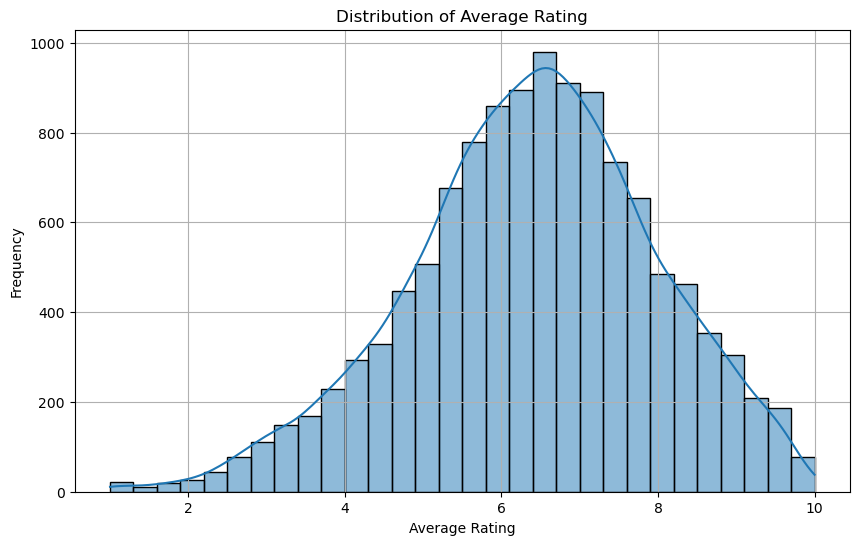

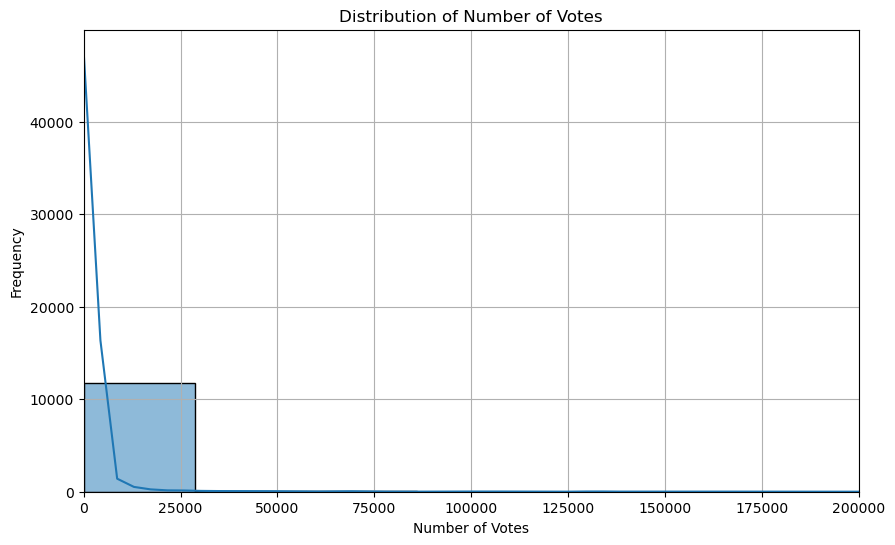

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot histogram for 'averageRating'
plt.figure(figsize=(10, 6))
sns.histplot(movies_2023['averageRating'], kde=True, bins=30)
plt.title('Distribution of Average Rating')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot histogram for 'numVotes'
plt.figure(figsize=(10, 6))
sns.histplot(movies_2023['numVotes'], kde=True, bins=30)
plt.title('Distribution of Number of Votes')
plt.xlabel('Number of Votes')
plt.ylabel('Frequency')
plt.xlim(0,200000)
plt.grid(True)
plt.show()


In [14]:
movies_2023["numVotes"].describe()

count     11886.000000
mean       2108.497224
std       17322.585840
min           5.000000
25%          18.000000
50%          62.000000
75%         314.750000
max      860004.000000
Name: numVotes, dtype: float64

In [15]:
# Fill missing 'averageRating' with the mean of the column
movies_2023['averageRating'] = movies_2023['averageRating'].fillna(movies_2023['averageRating'].mean())

# Fill missing 'numVotes' with the median of the column
movies_2023['numVotes'] = movies_2023['numVotes'].fillna(movies_2023['numVotes'].median())


In [16]:
movies_2023.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22433 entries, 69142 to 11488494
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tconst          22433 non-null  object 
 1   titleType       22433 non-null  object 
 2   primaryTitle    22433 non-null  object 
 3   originalTitle   22433 non-null  object 
 4   isAdult         22433 non-null  object 
 5   startYear       22433 non-null  object 
 6   endYear         22433 non-null  object 
 7   runtimeMinutes  22433 non-null  object 
 8   genres          22433 non-null  object 
 9   averageRating   22433 non-null  float64
 10  numVotes        22433 non-null  float64
dtypes: float64(2), object(9)
memory usage: 2.1+ MB


In [17]:
genres = set()
title_basics['genres'].apply(lambda x: genres.update(x.split(',')) if isinstance(x, str) else False)
genres

{'Action',
 'Adult',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Film-Noir',
 'Game-Show',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'News',
 'Reality-TV',
 'Romance',
 'Sci-Fi',
 'Short',
 'Sport',
 'Talk-Show',
 'Thriller',
 'War',
 'Western',
 '\\N'}

### Check for Duplicates

In [18]:
movies_2023.duplicated().any()

False

### Descriptive Statistics

In [19]:
movies_2023.describe(include="all")

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
count,22433,22433,22433,22433,22433,22433,22433,22433,22433,22433.000000,22433.000000
unique,22433,2,22073,22148,2,1,1,253,573,NaN,NaN
top,tt9897230,movie,Maria,Maria,0,2023,\N,\N,Documentary,NaN,NaN
freq,1,20383,4,4,22375,22433,22433,6282,5505,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.376216,1146.325146
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.145004,12650.238362
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,5.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.300000,53.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.376216,62.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.600000,74.000000


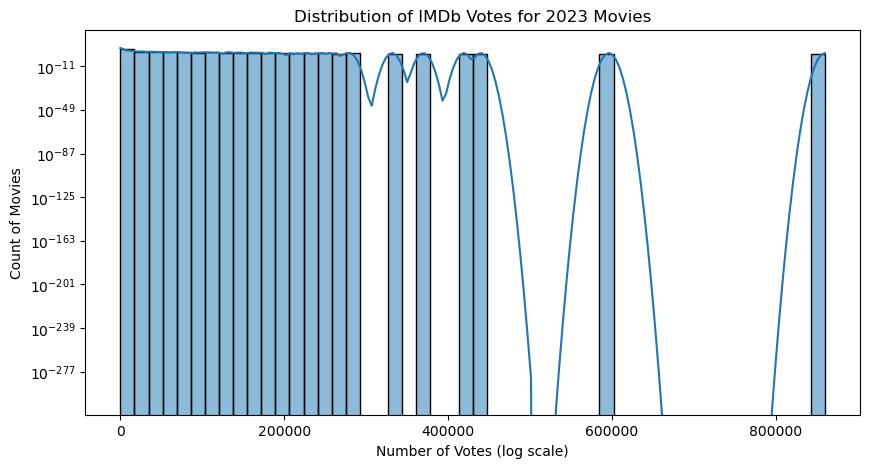

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot histogram of numVotes
plt.figure(figsize=(10,5))
sns.histplot(movies_2023["numVotes"], bins=50, kde=True)
# plt.xscale("log")  # Log scale to handle skewed data
plt.yscale("log")
plt.xlabel("Number of Votes (log scale)")
plt.ylabel("Count of Movies")
plt.title("Distribution of IMDb Votes for 2023 Movies")
plt.show()


In [21]:
percentiles = movies_2023["numVotes"].quantile([0.25, 0.5, 0.75, 0.80, 0.85, 0.90, 0.95, 0.99])
print(f"{percentiles}")

0.25       53.00
0.50       62.00
0.75       74.00
0.80      133.00
0.85      243.00
0.90      551.00
0.95     1652.40
0.99    16915.84
Name: numVotes, dtype: float64


In [22]:
movies_2023.shape

(22433, 11)

$$
\mathbb{P}(R|v) = \frac{v}{v + m} R + \frac{m}{v + m} C
$$

where:

$$
\begin{aligned}
R &= \text{average rating of the movie} \\
v &= \text{number of votes for the movie} \\
m &= \text{minimum votes required for consideration} \\
C &= \text{mean rating across all qualifying movies}
\end{aligned}
$$


references
* Ranking Products Based on Bayesian Estimation of Ratings (J. M. Bernardo, 2003)
* Recommender Systems Handbook (Ricci, Rokach, & Shapira, 2015)

In [23]:
# highest_rated_movie2023 = movies_2023.sort_values(by="averageRating", ascending=False).iloc[0]; 
# print(f"Highest Rated Movie in 2023: {highest_rated_movie2023["primaryTitle"]}")
# print(f"Average Rating: {highest_rated_movie2023["averageRating"]}")
# print(f"Number of Votes: {highest_rated_movie2023["numVotes"]}")


#Compute the Mean Rating Across All Movies
C = movies_2023["averageRating"].mean()

#Set the Minimum Votes Threshold for the 0.80 to 0.92 quantile range
m_lower = movies_2023["numVotes"].quantile(0.80)  # 80th percentile
m_upper = movies_2023["numVotes"].quantile(0.95)  

#Filter Movies with Votes Between 80th and 92nd Percentiles
qualified_movies = movies_2023[movies_2023["numVotes"] >= m_lower].copy()

# Step 4: Apply Weighted Rating (WR) Formula
def weighted_rating(df, m=1000, C=C):
    v = df["numVotes"]
    R = df["averageRating"]
    return (v / (v + m) * R) + (m / (v + m) * C)

#Apply Weighted Rating (WR) Formula
qualified_movies.loc[:, "WR"] = qualified_movies.apply(weighted_rating, axis=1)

#Get the Top Movie Based on WR
highest_rated_movie2023 = qualified_movies.sort_values(by="WR", ascending=False).iloc[0]

print(f"Highest Rated Movie in 2023: {highest_rated_movie2023['primaryTitle']}")
print(f"Weighted Rating: {highest_rated_movie2023['WR']}")
print(f"Average Rating: {highest_rated_movie2023['averageRating']}")
print(f"Number of Votes: {highest_rated_movie2023['numVotes']}")


Highest Rated Movie in 2023: 12th Fail
Weighted Rating: 8.78323649924245
Average Rating: 8.8
Number of Votes: 143587.0


In [24]:
qualified_movies.sort_values(by="WR", ascending=False)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,WR
6004445,tt23849204,movie,12th Fail,12th Fail,0,2023,\N,147,"Biography,Drama",8.8,143587.0,8.783236
11241112,tt9362722,movie,Spider-Man: Across the Spider-Verse,Spider-Man: Across the Spider-Verse,0,2023,\N,140,"Action,Adventure,Animation",8.5,439720.0,8.495181
6046803,tt24082438,movie,20 Days in Mariupol,20 Days in Mariupol,0,2023,\N,95,"Documentary,War",8.5,24947.0,8.418149
6617598,tt27719898,movie,Kaiva,Kaiva,0,2023,\N,138,"Action,Drama,Romance",8.4,68965.0,8.371074
5532150,tt21626284,movie,Lost Ladies,Laapataa Ladies,0,2023,\N,122,"Comedy,Drama",8.4,49573.0,8.359983
...,...,...,...,...,...,...,...,...,...,...,...,...
2148609,tt12132908,movie,Chandramukhi 2,Chandramukhi 2,0,2023,\N,172,"Action,Comedy,Drama",2.6,3399.0,3.458426
3842953,tt15281656,movie,The Holy Trinity,The Holy Trinity,0,2023,\N,80,Horror,3.1,12300.0,3.346332
2789412,tt13334578,movie,Ganapath,Ganapath,0,2023,\N,133,"Action,Drama,Sci-Fi",2.7,10503.0,3.019588
5044206,tt19623240,movie,Winnie-the-Pooh: Blood and Honey,Winnie-the-Pooh: Blood and Honey,0,2023,\N,84,Horror,2.9,33188.0,3.001679


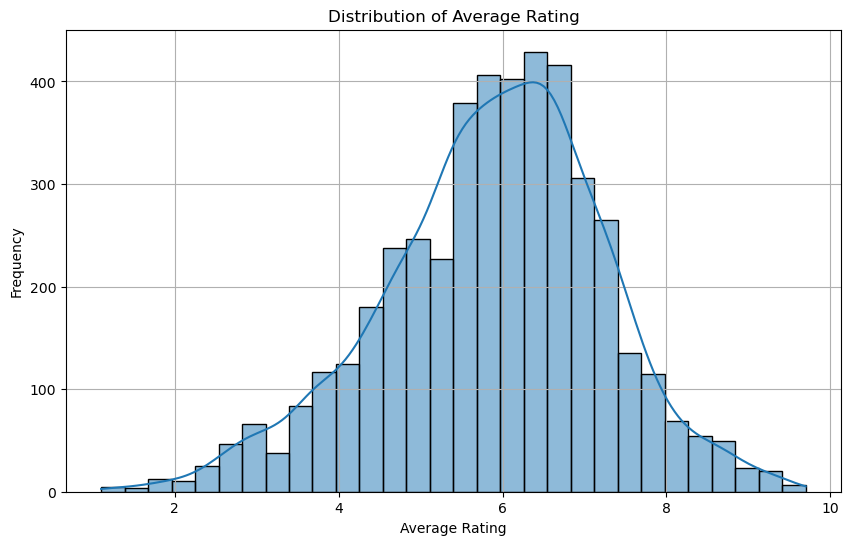

In [25]:
# Plot histogram for 'averageRating'
plt.figure(figsize=(10, 6))
sns.histplot(qualified_movies['averageRating'], kde=True, bins=30)
plt.title('Distribution of Average Rating')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

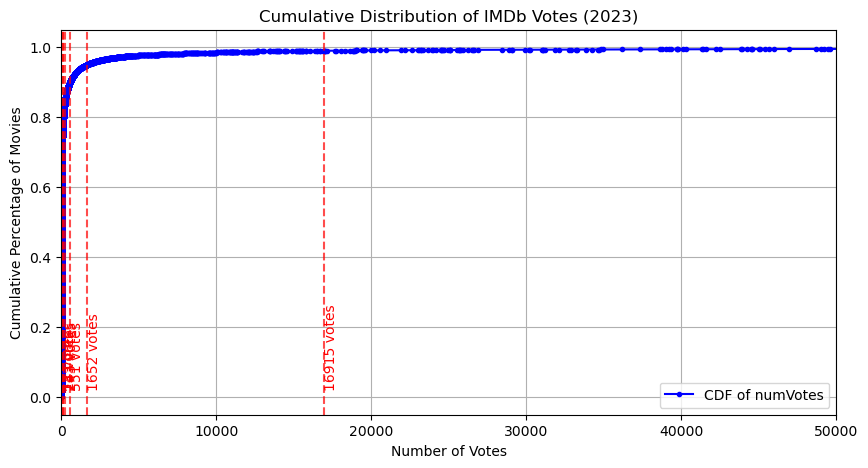

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Sort numVotes in ascending order
numVotes_sorted = np.sort(movies_2023["numVotes"])

# Compute CDF (cumulative percentage of movies)
cdf = np.arange(1, len(numVotes_sorted) + 1) / len(numVotes_sorted)

# Compute key percentiles
percentiles = movies_2023["numVotes"].quantile([0.75, 0.80, 0.85, 0.90, 0.95, 0.99])

# Plot CDF
plt.figure(figsize=(10,5))
plt.plot(numVotes_sorted, cdf, marker=".", linestyle="-", color="blue", label="CDF of numVotes")

# Mark key percentiles
for q in percentiles:
    plt.axvline(q, linestyle="dashed", color="red", alpha=0.7)
    plt.text(q, 0.02, f"{int(q)} votes", rotation=90, verticalalignment="bottom", color="red")

# Labels & Title
plt.xlabel("Number of Votes")
plt.ylabel("Cumulative Percentage of Movies")
plt.xlim(0,50000)
plt.title("Cumulative Distribution of IMDb Votes (2023)")
plt.grid(True)
plt.legend()

# Show plot
plt.show()


In [27]:
movie_highest_votes = movies_2023[movies_2023["numVotes"] == np.max(movies_2023["numVotes"])]
movie_highest_votes["primaryTitle"]

3904986    Oppenheimer
Name: primaryTitle, dtype: object

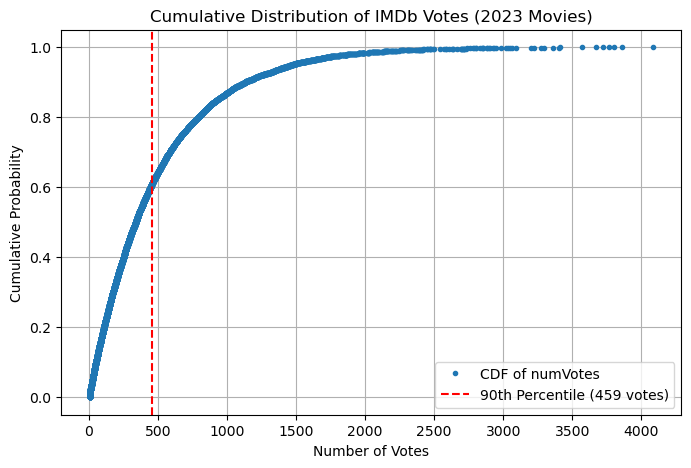

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Replace this with your actual `movies_2023_filtered["numVotes"]` data
np.random.seed(42)
num_votes = np.random.exponential(scale=500, size=10000)  # Simulating a skewed vote distribution
num_votes = np.clip(num_votes, 5, 10000)  # Clamping values to a reasonable range

# Sort votes for cumulative distribution
votes_sorted = np.sort(num_votes)

# Compute cumulative distribution
cdf = np.arange(len(votes_sorted)) / len(votes_sorted)

plt.figure(figsize=(8,5))
plt.plot(votes_sorted, cdf, marker=".", linestyle="none", label="CDF of numVotes")
plt.axvline(x=459, color="r", linestyle="--", label="90th Percentile (459 votes)")
plt.xlabel("Number of Votes")
plt.ylabel("Cumulative Probability")
plt.title("Cumulative Distribution of IMDb Votes (2023 Movies)")
plt.legend()
plt.grid()
plt.show()


## Title Crew

In [29]:
title_crew = pd.read_csv("title.crew.tsv", sep="\t", low_memory=False)

FileNotFoundError: [Errno 2] No such file or directory: 'title.crew.tsv'

## Name Basics

In [28]:
filtered_data_name_basic = []

for chunk in pd.read_csv("name.basics.tsv", sep="\t", chunksize=10000):
    filtered_data_name_basic.append(chunk)


name_basic = pd.concat(filtered_data_name_basic, ignore_index=True)

## Title Principals

In [29]:
filtered_data = []

# Read the file in chunks
chunk_size = 10000  # Adjust the chunk size based on your memory capacity
for chunk in pd.read_csv("title.principals.tsv", sep='\t', chunksize=chunk_size, low_memory=False):
    filtered_data.append(chunk)

# Concatenate the filtered chunks into a single DataFrame
title_principals = pd.concat(filtered_data, ignore_index=True)

In [32]:
name_basic

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899,1987,"actor,miscellaneous,producer","tt0072308,tt0050419,tt0027125,tt0031983"
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack,archive_footage","tt0037382,tt0075213,tt0117057,tt0038355"
2,nm0000003,Brigitte Bardot,1934,\N,"actress,music_department,producer","tt0057345,tt0049189,tt0056404,tt0054452"
3,nm0000004,John Belushi,1949,1982,"actor,writer,music_department","tt0072562,tt0077975,tt0080455,tt0078723"
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0050986,tt0069467,tt0050976,tt0083922"
...,...,...,...,...,...,...
14230072,nm9993714,Romeo del Rosario,\N,\N,"animation_department,art_department","tt11657662,tt14069590,tt2455546"
14230073,nm9993716,Essias Loberg,\N,\N,\N,\N
14230074,nm9993717,Harikrishnan Rajan,\N,\N,cinematographer,tt8736744
14230075,nm9993718,Aayush Nair,\N,\N,cinematographer,tt8736744


In [36]:
# title_principals = pd.read_csv("title.principals.tsv", sep="\t", low_memory=False)
# names_basics = pd.read_csv("names.basics.tsv", sep="\t", low_memory=False)

# Filter for 2023 movies and actors
actors_2023 = title_principals[title_principals["tconst"].isin(movies_2023["tconst"])]
actors_2023 = actors_2023[actors_2023["category"].isin(["actor", "actress"])]

# Merge with names.basics to get actor names
actors_2023 = actors_2023.merge(name_basic, on="nconst", how="left")

# Count the number of movies per actor
popular_actors = actors_2023["primaryName"].value_counts().reset_index()
popular_actors.columns = ["Actor", "Number of Movies"]

# Get the most popular actor
most_popular_actor = popular_actors.iloc[0]
print(f"Most Popular Actor in 2023: {most_popular_actor['Actor']} (Appeared in {most_popular_actor['Number of Movies']} movies)")

Most Popular Actor in 2023: Jason Young (Appeared in 89 movies)


In [30]:
# Split the 'knownForTitles' column into a list of titles
name_basic["knownForTitles"] = name_basic["knownForTitles"].str.split(",")

# Explode the list into separate rows
names_basic = name_basic.explode("knownForTitles")

# Merge with title_ratings to get ratings for known titles
names_with_ratings = names_basic.merge(title_ratings, left_on="knownForTitles", right_on="tconst", how="left")

In [43]:
# Group by person and calculate mean, median, and std of ratings
popularity_index = names_with_ratings.groupby("nconst").agg(
    Mean_Rating=("averageRating", "mean"),
    Median_Rating=("averageRating", "median"),
    Std_Rating=("averageRating", "std")
).reset_index()

# Merge back with names_basics to get actor names
popularity_index = popularity_index.merge(names_basic[["nconst", "primaryName"]], on="nconst", how="left")

In [78]:
# Filter for actors/actresses in 2023 movies
actors_2023 = title_principals[
    (title_principals["tconst"].isin(movies_2023["tconst"])) & 
    (title_principals["category"].isin(["actor", "actress"]))
]

# Merge with popularity_index to get their scores
actors_2023 = actors_2023.merge(popularity_index, on="nconst", how="left")

In [42]:
qualified_movies["tconst"]

69142        tt0070596
421679       tt0439572
975693       tt1001520
988226      tt10037498
991015      tt10042482
               ...    
11471946     tt9861230
11474862     tt9867628
11477104     tt9872558
11477491     tt9873376
11477745     tt9873892
Name: tconst, Length: 4499, dtype: object

In [79]:
actors_2023 = actors_2023.merge(qualified_movies[["tconst", "WR"]], on="tconst", how="left")

In [80]:
actors_2023.columns

Index(['tconst', 'ordering', 'nconst', 'category', 'job', 'characters',
       'Mean_Rating', 'Median_Rating', 'Std_Rating', 'primaryName', 'WR'],
      dtype='object')

In [84]:
# Merge with qualified movies to get WR for each movie
# actors_2023 = actors_2023.merge(qualified_movies[["tconst", "WR"]], on="tconst", how="left")

# Calculate a combined score (e.g., weighted average of Popularity Index and WR)
actors_2023["Combined Score"] = (
    0.4 * actors_2023["Mean_Rating"] +  # Weight for mean rating
    0.1 * actors_2023["WR"] +           # Weight for WR of 2023 movies
    0.4 * actors_2023["Median_Rating"] - # Weight for median rating
    0.1* (actors_2023["Std_Rating"])  # Weight for consistency (lower std = better)
)


# Group by actor and sum the Combined Scores
actor_scores = actors_2023.groupby("primaryName")["Combined Score"].sum().reset_index()

# Sort by Combined Score to get the most popular actor
most_popular_actor = actor_scores.sort_values(by="Combined Score", ascending=False).iloc[0]
print(f"Most Popular Actor in 2023: {most_popular_actor['primaryName']} (Combined Score: {most_popular_actor['Combined Score']:.2f})")

Most Popular Actor in 2023: Yogi Babu (Combined Score: 472.40)


# next

In [146]:
movies["startYear"] = pd.to_numeric(movies["startYear"], errors="coerce")
movies_new = movies[movies["startYear"] >= 2015]


In [147]:
# movies_new = movies_new.drop(columns=["originalTitle", "isAdult", "endYear", "runtimeMinutes"])
movies_new.isna().sum()


tconst                  0
titleType               0
primaryTitle           10
originalTitle          10
isAdult                 0
startYear               0
endYear                 0
runtimeMinutes          0
genres                  0
averageRating     3923869
numVotes          3923869
dtype: int64

In [148]:
movies_new = movies_new.dropna(subset=["averageRating", "numVotes"])
movies_new["primaryTitle"] = movies_new["primaryTitle"].fillna("Unknown Title")


In [149]:
movies_new

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
55746,tt0056840,short,Aufsätze,Aufsätze,0,2021.0,\N,10,Short,6.8,97.0
56269,tt0057369,short,Number 14: Late Superimpositions,Number 14: Late Superimpositions,0,2023.0,\N,30,Short,5.6,73.0
59190,tt0060361,short,EMS nr 1,EMS nr 1,0,2016.0,\N,14,Short,6.5,6.0
61103,tt0062336,movie,The Tango of the Widower and Its Distorting Mi...,El tango del viudo y su espejo deformante,0,2020.0,\N,70,Drama,6.4,228.0
67655,tt0069049,movie,The Other Side of the Wind,The Other Side of the Wind,0,2018.0,\N,122,Drama,6.7,8259.0
...,...,...,...,...,...,...,...,...,...,...,...
11497424,tt9916578,tvEpisode,The Trial of Joan Collins,The Trial of Joan Collins,0,2019.0,\N,44,"Adventure,Biography,Comedy",7.4,48.0
11497448,tt9916628,tvEpisode,A lenda do soprador de vidro,A lenda do soprador de vidro,0,2019.0,\N,\N,Comedy,8.6,9.0
11497494,tt9916730,movie,6 Gunn,6 Gunn,0,2017.0,\N,116,Drama,7.0,12.0
11497510,tt9916766,tvEpisode,Episode #10.15,Episode #10.15,0,2019.0,\N,43,"Family,Game-Show,Reality-TV",7.2,24.0


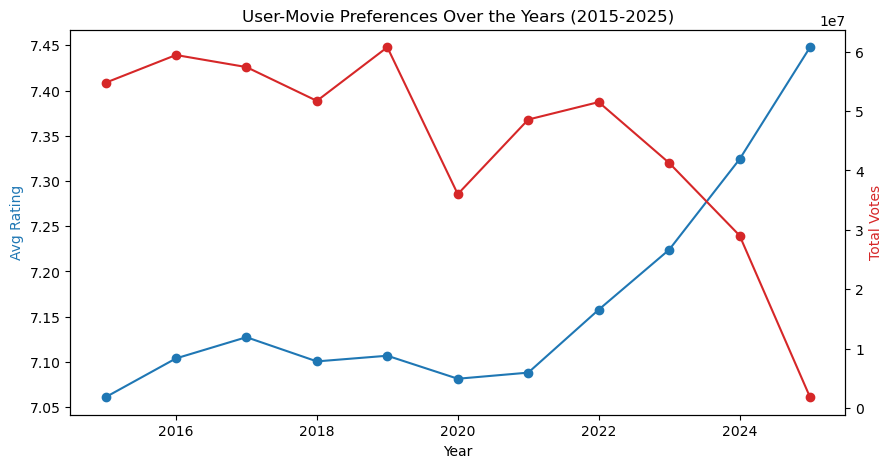

In [139]:
yearly_trends = movies_new.groupby("startYear").agg(
    avg_rating=("averageRating", "mean"),
    total_votes=("numVotes", "sum"),
    movie_count=("tconst", "count")
).reset_index()

import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10,5))

ax1.set_xlabel("Year")
ax1.set_ylabel("Avg Rating", color="tab:blue")
ax1.plot(yearly_trends["startYear"], yearly_trends["avg_rating"], marker="o", color="tab:blue", label="Avg Rating")

ax2 = ax1.twinx()
ax2.set_ylabel("Total Votes", color="tab:red")
ax2.plot(yearly_trends["startYear"], yearly_trends["total_votes"], marker="o", color="tab:red", label="Total Votes")

plt.title("User-Movie Preferences Over the Years (2015-2025)")
plt.show()


In [159]:
# Count individual genres
genre_counts = movies_new.explode("genres")["genres"].value_counts()

print(genre_counts.head(10))  # Check top genres


genres
Drama          203551
Comedy         177779
Documentary     89608
Action          74003
Animation       70236
Crime           67350
Short           62615
Adventure       62129
Reality-TV      51675
Romance         50839
Name: count, dtype: int64


In [153]:
genre_counts = movies_exploded["genres"].value_counts()
genre_counts

Series([], Name: count, dtype: int64)

In [158]:
movies_new.explode("genres")["genres"].value_counts()

genres
Drama          203551
Comedy         177779
Documentary     89608
Action          74003
Animation       70236
Crime           67350
Short           62615
Adventure       62129
Reality-TV      51675
Romance         50839
Thriller        33803
Mystery         32356
Horror          30221
Family          27553
Fantasy         26837
Talk-Show       25767
Game-Show       23745
History         20960
Music           16694
Biography       15192
Sport           14778
Sci-Fi          14595
News            10706
\N               4055
War              3618
Musical          3329
Adult            2928
Western          1517
Name: count, dtype: int64

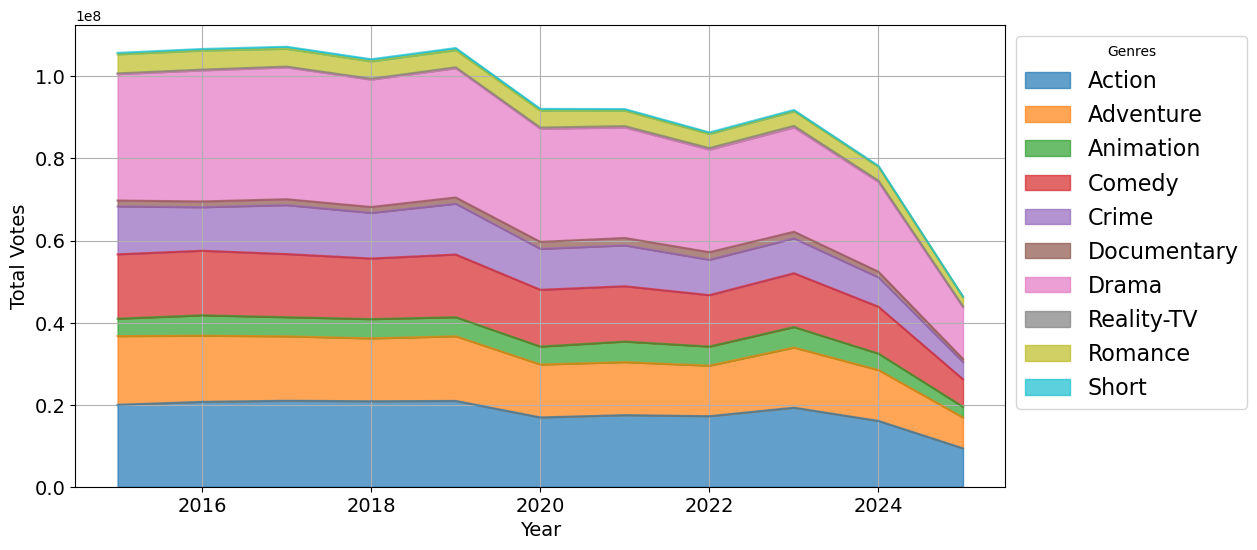

In [178]:
import matplotlib.pyplot as plt

# Explode genres into separate rows
movies_exploded = movies_new.explode("genres")

# Keep only the top 10 genres
top_genres = movies_exploded["genres"].value_counts().head(10).index.tolist()


# Filter using exploded dataset
filtered_movies = movies_exploded[movies_exploded["genres"].isin(top_genres)]; filtered_movies

# Aggregate votes per year and genre
genre_trends = (
    filtered_movies.groupby(["startYear", "genres"])
    .agg(total_votes=("numVotes", "sum"))
    .reset_index()
)

# Pivot for plotting
genre_trends_pivot = genre_trends.pivot(index="startYear", columns="genres", values="total_votes").fillna(0)

# Debugging: Ensure data is numeric and non-empty
# print(genre_trends_pivot.head())  
# print(genre_trends_pivot.dtypes)  

# # Apply rolling average for smoothing
genre_trends_pivot = genre_trends_pivot.rolling(window=3, min_periods=1).mean()

# Plot
genre_trends_pivot.plot(kind="area", stacked=True, figsize=(12, 6), alpha=0.7)
# plt.title("Votes per Genre Over Time (Smoothed)")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Total Votes", fontsize=14)
plt.legend(title="Genres", bbox_to_anchor=(1, 1), fontsize=16)
plt.grid(True)
plt.show()
